# A/B тесты

## Описание проекта
Задача — провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Требуется:
- Оценить корректность проведения теста
  - проверить пересечение тестовой аудитории с конкурирующим тестом,
  - проверить совпадение теста и маркетинговых событий, другие проблемы временных границ теста
- Проанализировать результаты теста
 

## Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: `2020-12-07`;
- дата остановки набора новых пользователей: `2020-12-21`;
- дата остановки: `2021-01-04`;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.



In [1]:
# импорт библиотек 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as mth
from scipy import stats as st


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# загрузка файлов
marketing_events = pd.read_csv('https://raw.githubusercontent.com/XeniaMishina/final_project/main/ab_project_marketing_events.csv')
new_users = pd.read_csv('https://raw.githubusercontent.com/XeniaMishina/final_project/main/final_ab_new_users.csv')
events = pd.read_csv('https://raw.githubusercontent.com/XeniaMishina/final_project/main/final_ab_events.csv')
participants = pd.read_csv('https://raw.githubusercontent.com/XeniaMishina/final_project/main/final_ab_participants.csv')

In [4]:
events.duplicated().sum()

0

## Исследование данных

In [5]:
# функция, дающая общую информацию о датасете
def first_impression(df):
    print()
    print('Первые 5 строк данных:')
    display(df.head())
    print('\n')
    print('Общая информация о данных:\n')
    print(df.info())
    print('\n')
    print(f'Количество полных строк-дубликатов = {df.duplicated().sum()},')
    print(f'что составляет {(df.duplicated().sum() / len(df)):.3%} датафрейма')

### События

In [6]:
print(marketing_events.info())
marketing_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Здесь все хорошо, только приведем даты к нужному типу данных.

In [7]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

marketing_events.info()
marketing_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Теперь можно двигаться дальше.

### Новые пользователи

In [8]:
first_impression(new_users)


Первые 5 строк данных:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone




Общая информация о данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


Количество полных строк-дубликатов = 0,
что составляет 0.000% датафрейма


Данные полные, нужно только привести дату к нужному типу.

In [9]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


Можем двигаться дальше.

### События

In [10]:
first_impression(events)


Первые 5 строк данных:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99




Общая информация о данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None


Количество полных строк-дубликатов = 0,
что составляет 0.000% датафрейма


Пропуски есть только в столбце `details`, что совершенно нормально, так как не для всех событий есть описание, для покупок там хранится цена, остальные действия пусты. Пропуски в этом столбце нормальны.

 Приведем дату к нужному типу, в остальном все в порядке.

In [11]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [12]:
events.query('event_name == "purchase"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62740 entries, 0 to 62739
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     62740 non-null  object        
 1   event_dt    62740 non-null  datetime64[ns]
 2   event_name  62740 non-null  object        
 3   details     62740 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.4+ MB


Для покупок все цены на месте. Здесь данные в норме. Двигаемся дальше.

### Участники

In [13]:
first_impression(participants)


Первые 5 строк данных:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test




Общая информация о данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


Количество полных строк-дубликатов = 0,
что составляет 0.000% датафрейма


Здесь все в норме. Идем дальше.

## Оценка корректности проведения теста

### Соответствие данных требованиям технического задания




**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: `2020-12-07`;
- дата остановки набора новых пользователей: `2020-12-21`;
- дата остановки: `2021-01-04`;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

In [14]:
# объединим датафреймы пользователей и участников теста
participants = participants.merge(new_users, on='user_id', how='left')
participants

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test,2020-12-15,EU,PC
18264,3DE51B726983B657,A,interface_eu_test,2020-12-07,EU,Android
18265,F501F79D332BE86C,A,interface_eu_test,2020-12-17,EU,Mac
18266,63FBE257B05F2245,A,interface_eu_test,2020-12-20,EU,Android


In [15]:
# название теста: recommender_system_test
participants_filtered = participants.query('ab_test == "recommender_system_test"')

participants_filtered

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android
6697,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac
6698,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac
6699,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android


In [16]:
# дата запуска: 2020-12-07
participants_filtered['first_date'].min()

Timestamp('2020-12-07 00:00:00')

Все совпадает.



In [17]:
# дата остановки набора новых пользователей: 2020-12-21
participants_filtered['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Корректно.

In [18]:
# дата остановки: 2021-01-04
events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

Все верно. События закончились даже раньше.  
Но получается, что многие пользователи не успели прожить 14 дней. Это может плохо повлиять на корректность результатов теста, так как ожидалось, что все проживут минимум 2 недели.


In [19]:
# Проверим, что каждый пользователь состоит лишь в одной группе
participants_filtered

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android
6697,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac
6698,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac
6699,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android


In [20]:
# аудитория: 15% новых пользователей из региона EU
participants_filtered = participants_filtered.query('region == "EU"')
EU_all = len(new_users[new_users['region'] == 'EU'])
EU_test = len(participants_filtered)
print(f"Всего в EU пользователей: {EU_all}")
print(f'В нашем тесте пользователей: {EU_test}')
print(f'Это{EU_test / EU_all: .2%} от общего числа пользователей.' )


Всего в EU пользователей: 46270
В нашем тесте пользователей: 6351
Это 13.73% от общего числа пользователей.


In [21]:
# посчитаем отличия с ТЗ в процентах
expected_amount_of_participants = 6000
expected_percent_of_EU_participants = 15

print(f"Отличие с ТЗ по количеству пользователей: {abs(EU_test - expected_amount_of_participants) / max(EU_test, expected_amount_of_participants):.2%}")
print(f'Отличие с ТЗ по проценту европейской аудитории: {abs(expected_percent_of_EU_participants - 100 * EU_test / EU_all) / max(expected_percent_of_EU_participants, 100 * EU_test / EU_all):.2%}')


Отличие с ТЗ по количеству пользователей: 5.53%
Отличие с ТЗ по проценту европейской аудитории: 8.49%


Мы захватили несколько меньший процент пользователей - 13.73%. Ожидаемое количество в 6000 практически соблюдено, в нашем тесте 6351 пользователь. 

Отклонения не так критичны, в целом здесь ТЗ соблюдено.

### Время проведения теста

In [22]:
marketing_events[('2020-11-07' <= marketing_events['start_dt']) & (marketing_events['start_dt'] <= '2021-01-04')]


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12


Так как мы находимся в регионе `EU`, то проведение теста выпадает на Рождество и Новый Год.  

За предшествующий началу теста месяц в интересующем регионе `EU` не проводилось больше никаких других кампаний.

Посмотрим, повлияло ли проведение новогодней/рождественской кампании на всплеск активности.

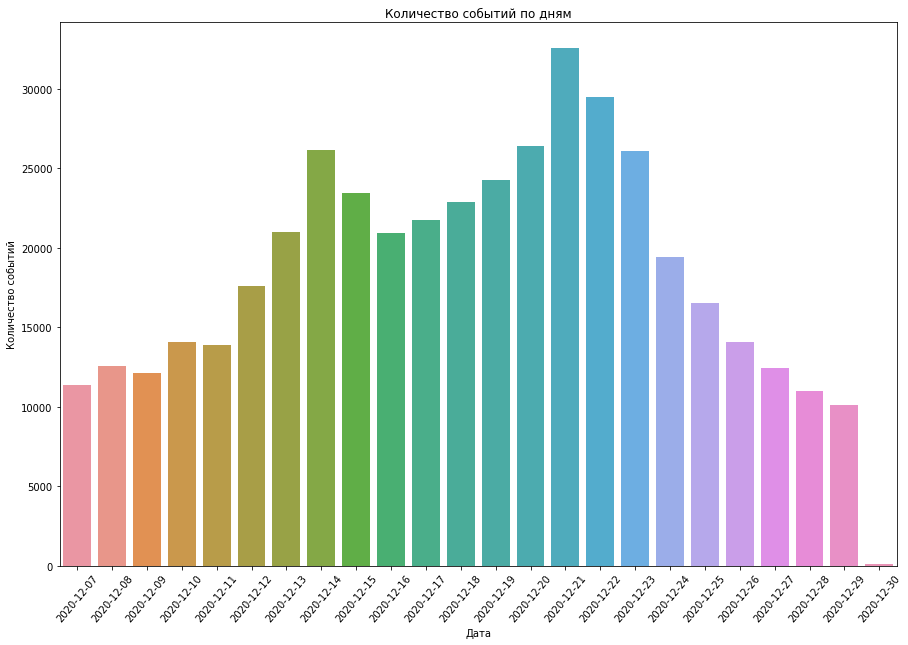

In [23]:
# посмотрим, повлияло ли это событие на всплеск активности
events['event_date'] = events['event_dt'].dt.date
events_per_day = events.groupby('event_date', as_index=False)['event_dt'].count().rename(columns={'event_dt': 'events_cnt'})

fig, ax = plt.subplots(figsize=(15,10))

sns.barplot(data=events_per_day, 
            x='event_date',
            y='events_cnt').set(title='Количество событий по дням')
plt.xticks(rotation=50)
plt.xlabel('Дата')
plt.ylabel('Количество событий');

Кажется, всплеска активности после 25 декабря не наблюдается, даже, скорее, наоборот. Посмотрим, может это повлияло на одну из групп.

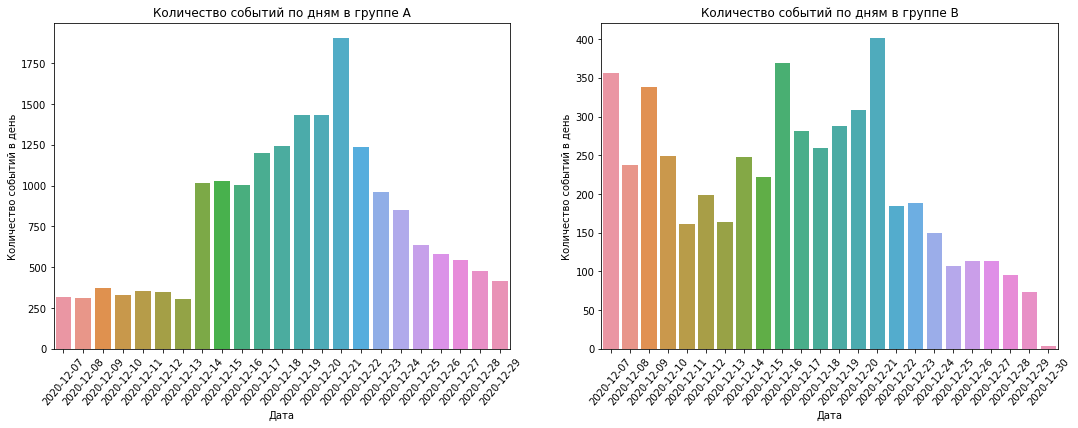

In [24]:
events_per_group = events.merge(participants_filtered, on='user_id', how='right')
events_A = events_per_group.query('group == "A"')
events_B = events_per_group.query('group == "B"')

events_A_cnt_per_day = events_A.groupby('event_date', as_index=False)['event_dt'].count().rename(columns={'event_dt': 'events_cnt'})
events_B_cnt_per_day = events_B.groupby('event_date', as_index=False)['event_dt'].count().rename(columns={'event_dt': 'events_cnt'})

fig, ax = plt.subplots(1, 2, figsize=(18,6))


fig1 = sns.barplot(data=events_A_cnt_per_day, 
                   x='event_date',
                   y='events_cnt',
                   ax=ax[0]).set(title='Количество событий по дням в группе A',
                                 xlabel='Дата',
                             ylabel='Количество событий в день')
plt.sca(ax[0])
plt.xticks(rotation=50)

fig1 = sns.barplot(data=events_B_cnt_per_day, 
                   x='event_date',
                   y='events_cnt',
                   ax=ax[1]).set(title='Количество событий по дням в группе B',
                                 xlabel='Дата',
                                 ylabel='Количество событий в день')
plt.sca(ax[1])
plt.xticks(rotation=50);


Для обеих групп рекламная компания в честь Рождества не повлияла на всплеск активности. Можем двигаться дальше.

### Аудитория теста

Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

In [25]:
# проверим, что пользователи нашего теста состоят лишь в олной группе этого теста
print(f'''Количество пользователей, состоящих одновременно в двух группах нашего теста: {
    len(participants_filtered.groupby('user_id', as_index=False)['group'].count().rename(columns={'group': 'group_cnt'}).query('group_cnt > 1'))
}''')


Количество пользователей, состоящих одновременно в двух группах нашего теста: 0


Распределение по группах с точки зрения не пересечения двух групп корректно. 

Теперь посчитаем размеры групп.

In [26]:
# посчитаем размеры групп

participants_A = participants_filtered.query('group == "A"')
participants_B = participants_filtered.query('group == "B"')
cnt_A, cnt_B = len(participants_A), len(participants_B)

print(f'Размер группы A: {cnt_A}\nРазмер группы B: {cnt_B}\nПроцентное различие размеров груп: {abs(cnt_B - cnt_A) / max(cnt_B, cnt_A):.2%}')


Размер группы A: 3634
Размер группы B: 2717
Процентное различие размеров груп: 25.23%


Размеры групп, конечно, ощутимо отличаются, но так как мы тестируем относительную метрику - конверсию, то в целом провести тест можно.

Посмотрим на пересечения с конкурирующим тестом.



In [27]:
# пересечения с конкурирующим тестом
participants_2_tests = participants.groupby('user_id', as_index=False)['ab_test'].count().rename(columns={'ab_test': 'test_cnt'}).query('test_cnt > 1')
print(f'Количество людей, участвующих в двух тестах одновременно: {len(participants_2_tests)}')

print()
print('Участники нашего теста, состоящие в группе B другого теста')
second_test_b_group = participants.query('group == "B" and ab_test == "interface_eu_test"').user_id.unique()
participants_filtered.query('user_id in @second_test_b_group')

Количество людей, участвующих в двух тестах одновременно: 1602

Участники нашего теста, состоящие в группе B другого теста


,user_id,group,ab_test,first_date,region,device
29,5D5E6EE92AF6E9E0,B,recommender_system_test,2020-12-21,EU,Android
44,FC3F3E4DA7C85F88,A,recommender_system_test,2020-12-20,EU,PC
49,FE2AF0E94DBD470E,A,recommender_system_test,2020-12-21,EU,Android
53,952D1EEBF552BC95,B,recommender_system_test,2020-12-21,EU,Android
60,C5AD06762E628169,A,recommender_system_test,2020-12-09,EU,Android
...,...,...,...,...,...,...
6305,32164CC8F884B9A5,A,recommender_system_test,2020-12-11,EU,Android
6309,7FE6DDDB6C85C934,A,recommender_system_test,2020-12-11,EU,iPhone
6311,8F72F2114F2D5184,B,recommender_system_test,2020-12-12,EU,PC
6318,96BDD55846D1F7F6,A,recommender_system_test,2020-12-20,EU,iPhone


Посмотрим, сколько из них принадлежат каждой из групп A и B нашего теста.

In [28]:
cnt_A_participate_in_other_test_B_group, cnt_B_participate_in_other_test_B_group = participants_filtered.query('user_id in @second_test_b_group')['group'].value_counts()
print(f'A: {cnt_A_participate_in_other_test_B_group}\nB: {cnt_B_participate_in_other_test_B_group}')


A: 439
B: 344


Посмотрим, сколько процентов каждой группы пересекаются с тестируемой группой B другого теста:

In [29]:
print(f'процент пересечения в группе A: {cnt_A_participate_in_other_test_B_group / cnt_A:.2%}\nпроцент пересечения в группе B: {cnt_B_participate_in_other_test_B_group / cnt_B:.2%}')

процент пересечения в группе A: 12.08%
процент пересечения в группе B: 12.66%


Так как проценты задействованых в другом тесте примерно равны, можно считать, что влияние, оказываемое другим тестом на группы, будет примерно одинаковым и на результаты нашего теста не повлияет. 


Посмотрим, есть ли в наших группах пользователи, не совершавших за время тестирование действий.

In [30]:
idle_participants_A = events_A.groupby('user_id', as_index=False)['event_name'].count().rename(columns={'event_name': 'events_cnt'}).query('events_cnt == 0')
idle_participants_B = events_B.groupby('user_id', as_index=False)['event_name'].count().rename(columns={'event_name': 'events_cnt'}).query('events_cnt == 0')

print(f'Количество бездействующих в группе A: {len(idle_participants_A)}\nКоличество бездействующих в группе B: {len(idle_participants_B)}')
print()
print(f'Процент бездействующих в группе A: {len(idle_participants_A) / cnt_A:.2%}\nПроцент бездействующих в группе B: {len(idle_participants_B) / cnt_B:.2%}')

Количество бездействующих в группе A: 1030
Количество бездействующих в группе B: 1840

Процент бездействующих в группе A: 28.34%
Процент бездействующих в группе B: 67.72%


В наших группах оказалось очень много мертвых душ, к тому же, в тестируемой группе их более, чем в два раза больше. Это может сильно повлиять на результаты теста.

## Исследовательский анализ данных

### Распределение количества событий на пользователя в разных группах

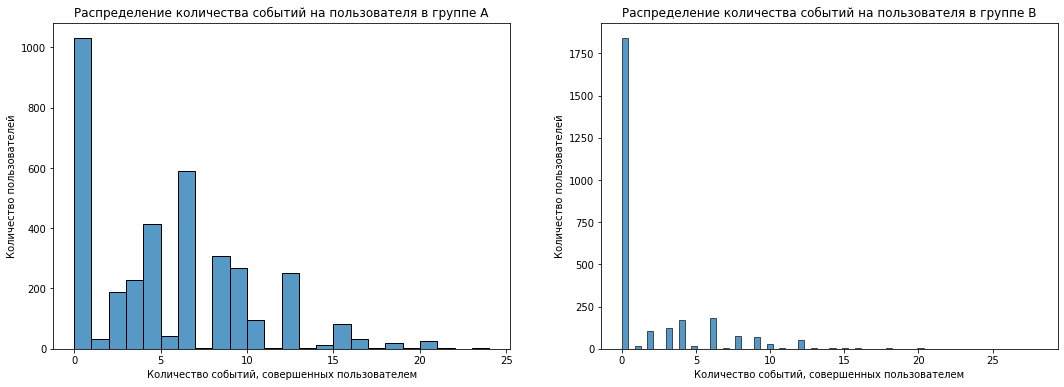

In [31]:
events_A_cnt_per_user = events_A.groupby('user_id', as_index=False)['event_dt'].count().rename(columns={'event_dt': 'events_cnt'})
events_B_cnt_per_user = events_B.groupby('user_id', as_index=False)['event_dt'].count().rename(columns={'event_dt': 'events_cnt'})

fig, ax = plt.subplots(1, 2, figsize=(18,6))


fig1 = sns.histplot(data=events_A_cnt_per_user, 
                   x='events_cnt',
                   ax=ax[0]).set(title='Распределение количества событий на пользователя в группе A',
                                 xlabel='Количество событий, совершенных пользователем',
                                 ylabel='Количество пользователей')
plt.sca(ax[0])


fig1 = sns.histplot(data=events_B_cnt_per_user, 
                   x='events_cnt',
                   ax=ax[1]).set(title='Распределение количества событий на пользователя в группе B',
                                 xlabel='Количество событий, совершенных пользователем',
                                 ylabel='Количество пользователей')
plt.sca(ax[1])



In [32]:
print('Распределение количества событий на пользователя в группе A')
display(events_A_cnt_per_user.describe(percentiles=[.5, .75, .95, .99]))
print()
print('Распределение количества событий на пользователя в группе B')
display(events_B_cnt_per_user.describe(percentiles=[.5, .75, .95, .99]))

Распределение количества событий на пользователя в группе A


,events_cnt
count,3634.000000
mean,5.038250
std,4.559231
min,0.000000
50%,4.000000
75%,8.000000
95%,12.000000
99%,18.000000
max,24.000000



Распределение количества событий на пользователя в группе B


,events_cnt
count,2717.000000
mean,1.881119
std,3.370506
min,0.000000
50%,0.000000
75%,3.000000
95%,9.000000
99%,12.000000
max,28.000000


Так как 99% значений количества событий на человека в обеих группах менее 20, то построим распределения в пределах 20 действий на пользователя.

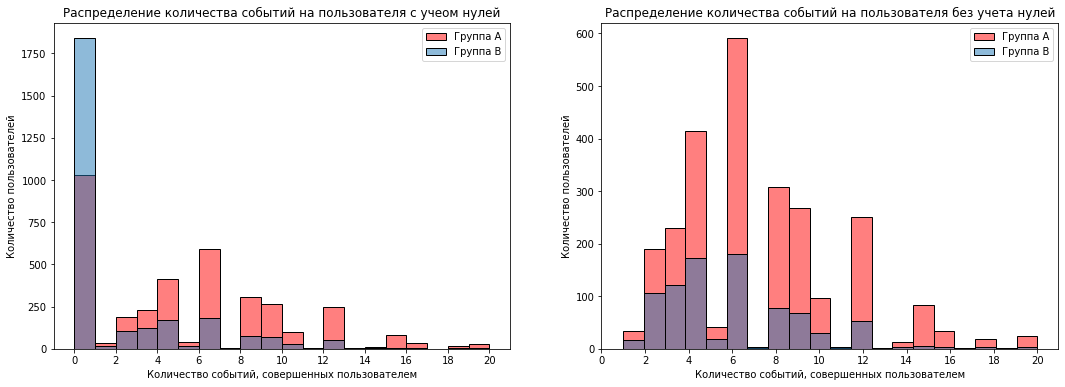

In [33]:
# строим те же распределения, избавившись от выбросов
fig, ax = plt.subplots(1, 2, figsize=(18,6))

fig1 = sns.histplot(data=events_A_cnt_per_user.query('events_cnt <= 20'), 
                   x='events_cnt',
                   bins=20,
                   color='red',
                   alpha=0.5,
                   label='Группа A',
                   ax=ax[0]).set(title='Распределение количества событий на пользователя с учеом нулей',
                                  xlabel='Количество событий, совершенных пользователем',
                                  ylabel='Количество пользователей')



fig1 = sns.histplot(data=events_B_cnt_per_user.query('events_cnt <= 20'), 
                   x='events_cnt',
                   bins=20,
                   alpha=0.5,
                   label='Группа B',
                   ax=ax[0])
plt.sca(ax[0])
ax[0].set_xticks(list(range(0, 21, 2)));
ax[0].legend()

fig2 = sns.histplot(data=events_A_cnt_per_user.query('events_cnt <= 20').query('events_cnt > 0'), 
                   x='events_cnt',
                   bins=20,
                   color='red',
                   alpha=0.5,
                   label='Группа A',
                   ax=ax[1]).set(title='Распределение количества событий на пользователя без учета нулей',
                                  xlabel='Количество событий, совершенных пользователем',
                                  ylabel='Количество пользователей')



fig2 = sns.histplot(data=events_B_cnt_per_user.query('events_cnt <= 20').query('events_cnt > 0'), 
                   x='events_cnt',
                   bins=20,
                   alpha=0.5,
                   label='Группа B',
                   ax=ax[1])
plt.sca(ax[1])
ax[1].set_xticks(list(range(0, 21, 2)))
ax[1].legend();

Распределения имеют одинаковую форму, однако в группе A пользователи сильно активнее пользователей в группе B. Но это объясняется тем, что в группе B большая часть пользователей неактивны.

In [34]:
print(f'Активных пользователей в группе A: {cnt_A - len(idle_participants_A)}')
print(f'Активных пользователей в группе B: {cnt_B - len(idle_participants_B)}')

Активных пользователей в группе A: 2604
Активных пользователей в группе B: 877


Отсюда и возника такая разница в абсолютных значениях. Но по форме распределения одинаковы.

### Распределение количества событий по дням в разных группах

Мы уже смотрели на это распределение. Взглянем еще раз.

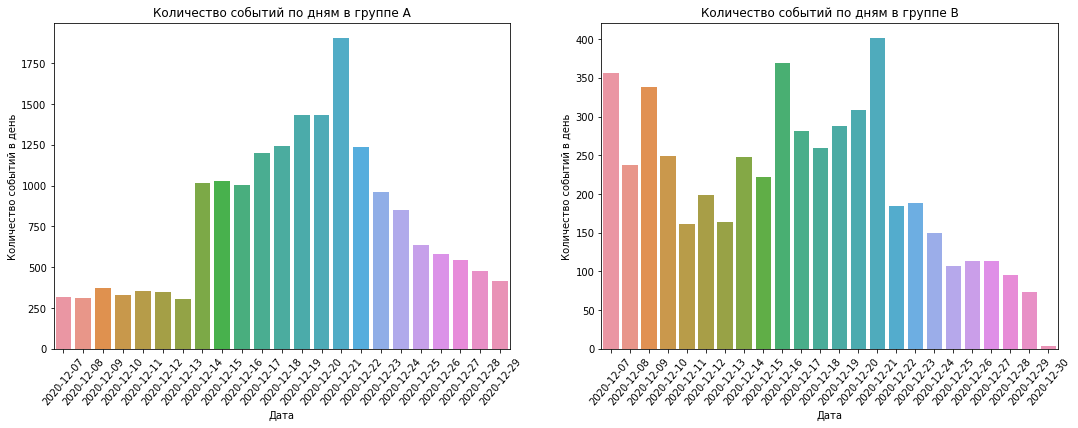

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))


fig1 = sns.barplot(data=events_A_cnt_per_day, 
                   x='event_date',
                   y='events_cnt',
                   ax=ax[0]).set(title='Количество событий по дням в группе A',
                                 xlabel='Дата',
                             ylabel='Количество событий в день')
plt.sca(ax[0])
plt.xticks(rotation=50)

fig1 = sns.barplot(data=events_B_cnt_per_day, 
                   x='event_date',
                   y='events_cnt',
                   ax=ax[1]).set(title='Количество событий по дням в группе B',
                                 xlabel='Дата',
                                 ylabel='Количество событий в день')
plt.sca(ax[1])
plt.xticks(rotation=50);

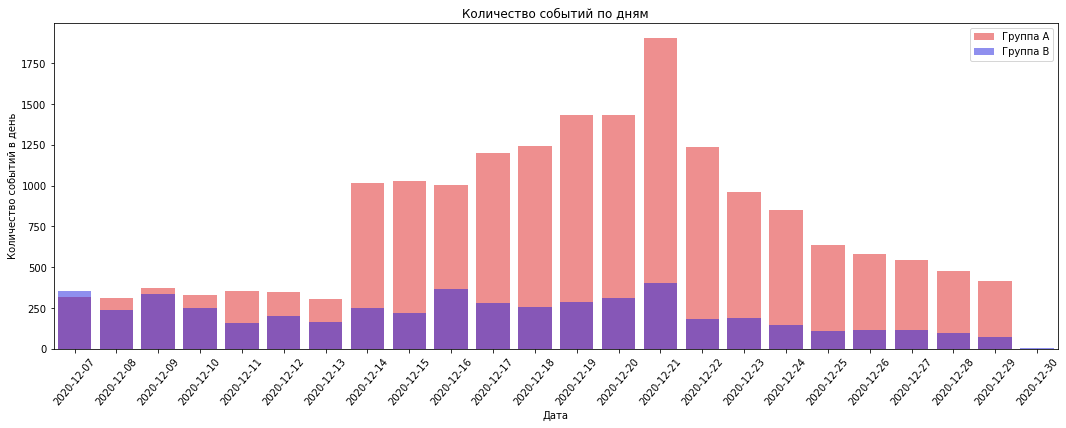

In [36]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(data=events_A_cnt_per_day, 
            x='event_date',
            y='events_cnt',
            label='Группа A',
            color='red',
            alpha=.5)


sns.barplot(data=events_B_cnt_per_day, 
            x='event_date',
            y='events_cnt',
            label='Группа B',
            color='blue',
            alpha=.5)

plt.title('Количество событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий в день')
plt.legend()
plt.xticks(rotation=50);

В группе B количество событий по дням практически не менялось, а вот в группе A 14 декабря случился всплеск активности. Распределения количество действий по дням сильно отличаются.  


Посомотрим на количество регистраций по дням для обеих групп.

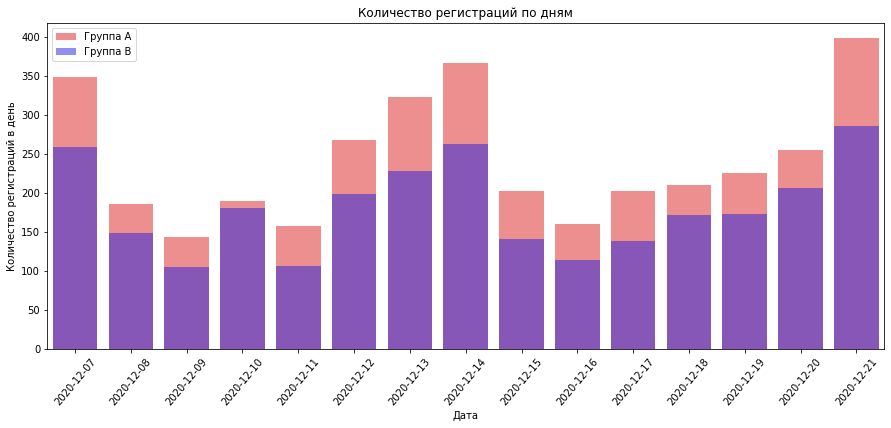

In [37]:
participants_filtered['first_date'] = pd.to_datetime(participants_filtered['first_date']).dt.date
registrations_A_cnt_per_day = participants_filtered.query('group == "A"').groupby('first_date', as_index=False)['user_id'].count().rename(columns={'user_id': 'reg_cnt'})
registrations_B_cnt_per_day = participants_filtered.query('group == "B"').groupby('first_date', as_index=False)['user_id'].count().rename(columns={'user_id': 'reg_cnt'})

fig, ax = plt.subplots(figsize=(15,6))

sns.barplot(data=registrations_A_cnt_per_day, 
            x='first_date',
            y='reg_cnt',
            label='Группа A',
            color='red',
            alpha=.5)


sns.barplot(data=registrations_B_cnt_per_day, 
            x='first_date',
            y='reg_cnt',
            label='Группа B',
            color='blue',
            alpha=.5)

plt.title('Количество регистраций по дням')
plt.xlabel('Дата')
plt.ylabel('Количество регистраций в день')
plt.legend()
plt.xticks(rotation=50);


Количество регистраций имеет примерно одну и ту же форму, абсолютные значения разные, но и количество пользователей в группе B меньше. Всплеск действий в группе A 14 декабря этим не объяснить.

### Как меняется конверсия в воронке в выборках на разных этапах?

In [38]:
funnel_df = events_per_group.pivot_table(index='event_name', 
                                         values='user_id', 
                                         columns='group', 
                                         aggfunc=lambda x: x.nunique())

funnel_df.sort_values(by ='A', ascending = False, inplace=True)
#funnel_df = funnel_df.reindex(['login', 'product_page', 'product_cart', 'purchase']).reset_index()
funnel_df


group,A,B
event_name,,
login,2604,877
product_page,1685,493
purchase,833,249
product_cart,782,244


In [39]:
from plotly import graph_objects as go

print('Группа A')

fig_A = go.Figure(
    go.Funnel(
        y=[
            'Посетителей',
            'Просмотр карточек товаров',
            'Просмотр корзины',
            'Покупка',
        ],
        x=[funnel_df['A']['login'], 
           funnel_df['A']['product_page'], 
           funnel_df['A']['product_cart'], 
           funnel_df['A']['purchase']],
        
    )
)

fig_A.show() 

print('\n\nГруппа B')

fig_B = go.Figure(
    go.Funnel(
        y=[
            'Посетителей',
            'Просмотр карточек товаров',
            'Просмотр корзины',
            'Покупка',
        ],
        x=[funnel_df['B']['login'], 
           funnel_df['B']['product_page'], 
           funnel_df['B']['product_cart'], 
           funnel_df['B']['purchase']],
        
    )
)

fig_B.show() 



Группа A




Группа B


Итак, в группе A до покупки дошло 32% посетителей, в группе B 28.4% посетителей. Для группы B показатели чуть меньше.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Группа A / Группа B**


просмотр товара &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**64.7% / 56.2%**

просмотр корзины &nbsp;&nbsp;&nbsp;**30.0% / 27.8%**  

покупка &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**32.0% / 28.4%**

Оказалось, что покупок больше, чем просмотров корзины. Вероятно, на сайте есть возможно быстрой покупки без просмотра страницы товара.

Улучшения метрик для группы B не последовало. 

**Все показатели для группы B ниже показателей для группы A.**

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

- Во-первых, группы были разного размера, отличие в 30% ощутимо может повлиять на исход, но так как мы тестировани относительные метрики, то это не настолько критично;
- Во-вторых, проведения тестирования перескается с проведением маркетинговых кампаний: Рождество и Новый Год
- В-третьих, большая часть участников параллельно участвовали в другом тестировании, что могло негативно повлиять на результат
- В-четвертых, в обеих группах очень много мертвых душ, которые вообще не совершали действий, причем в наименьшей группе их больше, что меняет соотношение групп еще больше
- В-пятых, многие пользователи не успели прожить 14 дней, их действия закончились раньше ожидаемого срока


В сумме все эти факторы могут очень сильно повлиять на результаты тестирования.

## Оценка результатов A/B-тестирования

In [40]:
# функция для z-test'а
def z_test(group_A, cnt_A, group_B, cnt_B, event, alpha=.05):
    
    successes = np.array([int(group_A[event]), int(group_B[event])])
    trials = np.array([cnt_A, cnt_B])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'alpha = {alpha}')
    
    print()

    print('p-значение: ', round(p_value, 6))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )     
        
    print()
    print()
    print('-' * 70)
    print()

 

Сформулируем гипотезы для всех проверок сразу:

**H0:** Доли совершивших действие среди общего количества пользователей для обеих групп одинаковы

**H1:** Доли совершивших действие среди общего количества пользователей различны для групп

In [41]:
events = ['product_page', 'product_cart', 'purchase']

for event in events:
    print(f'Z-test для события {event}')
    z_test(funnel_df['A'], funnel_df['A']['login'], funnel_df['B'], funnel_df['B']['login'], event, alpha=.05)

Z-test для события product_page
alpha = 0.05

p-значение:  7e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


----------------------------------------------------------------------

Z-test для события product_cart
alpha = 0.05

p-значение:  0.214692
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


----------------------------------------------------------------------

Z-test для события purchase
alpha = 0.05

p-значение:  0.046525
Отвергаем нулевую гипотезу: между долями есть значимая разница


----------------------------------------------------------------------



Попробуем с поправкой Бонферрони, так как сравниваем три конверсии, то будем делить alpha на 3.

In [42]:
# тест, используя поправку Бонферрони
for event in events:
    print(f'Z-test для события {event}')
    z_test(funnel_df['A'], funnel_df['A']['login'], funnel_df['B'], funnel_df['B']['login'], event, alpha=.05 / 3)

Z-test для события product_page
alpha = 0.016666666666666666

p-значение:  7e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


----------------------------------------------------------------------

Z-test для события product_cart
alpha = 0.016666666666666666

p-значение:  0.214692
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


----------------------------------------------------------------------

Z-test для события purchase
alpha = 0.016666666666666666

p-значение:  0.046525
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


----------------------------------------------------------------------



Получается, что есть основания считать доли разными, однако метрики только ухудшились.  

Тест показал, что группа B менее эффективна.

Мы не получили ожидаемого эффекта, заявленного в техническом задании.

## Выводы

**Исследовательский анализ данных:**

1. Группы были разного размера, отличие в 30% ощутимо может повлиять на исход, но так как мы тестировани относительные метрики, то это не настолько критично;
2. Проведение тестирования перескается с проведением маркетинговых кампаний: Рождество и Новый Год
3. Значительная часть участников параллельно участвовали в другом тестировании, что могло негативно повлиять на результат
4. В обеих группах очень много мертвых душ, которые вообще не совершали действий, причем в наименьшей группе их больше, что меняет соотношение групп еще больше
5. Многие пользователи не успели прожить 14 дней, их действия закончились раньше ожидаемого срока

В сумме все эти факторы могли очень сильно повлиять на результаты тестирования.

**A/B тестирование**

В техническом задании был заявлен ожидаемый результат в +10% к каждой конверсии на каждом этапе, на деле же конверсии в группе B только упали. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Группа A / Группа B**


просмотр товара &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**64.7% / 56.2%**

просмотр корзины &nbsp;&nbsp;&nbsp;**30.0% / 27.8%**  

покупка &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**32.0% / 28.4%**

Наиважнеший показатель - покупка - упал на 3.6%, 

A/B тестирование показало, что группа B была даже менее эффективна, чем группа A. 

Этот результат подкрепляет и z-test, который показал, что доли людей, просмотревших товары и купивших что-то -  действительно различны, и для группы B они меньше.

**Корректность тестирования**

Я бы не считала данное тестирование корректным, нельзя интрепретировать эти результаты как провал группы B. 

Исследовательский анализ выявил очень много факторов, негативно влияющих на корректность результатов тестирования (перечислены в начале). 

Стоит провести новое тестирование с более корректными данными, в которых будут правильные пропорции групп с похожими распределениями действий и в течение которого не будет внешних факторов, влияющих на этот тест.
